<a href="https://colab.research.google.com/github/PhiloAmgad/CVD-19-Diagnosis-using-ML/blob/main/GLCM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import os
import numpy as np
import nibabel as nib
import cv2 as cv
from sklearn import feature_selection
import scipy as sp
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import svm
from PIL import Image
import matplotlib as mpl
import imageio
import matplotlib.pyplot as plt

from IPython.display import display

from skimage.feature import hog
from skimage.color import rgb2grey
from skimage.io import imread

from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc

from google.colab.patches import cv2_imshow
from skimage.feature import greycomatrix, greycoprops
from skimage import data


import glob
import seaborn as sns
from skimage.filters import sobel
from skimage.measure import shannon_entropy
! pip install pyradiomics
import SimpleITK as sitk
import six
import logging
import radiomics
from radiomics import featureextractor, getTestCase, glcm



# data_path = 'C:\Philo\GUC\Semester 8'
# filename = os.path.join(data_path, r'C:\Philo\GUC\Semester 8\tr_im.nii\tr_im.nii')
# img = nib.load(filename)
# data = img.get_fdata()
# print(data)

     |████████████████████████████████| 188 kB 4.2 MB/s 
     |████████████████████████████████| 48.4 MB 32 kB/s 
     |████████████████████████████████| 109 kB 41.3 MB/s 
     |████████████████████████████████| 546 kB 40.3 MB/s 


In [ ]:
#transformations for matplot lib
mask_data = nib.load(r'drive/MyDrive/Semester 8/tr_mask.nii').get_fdata()
func_data = nib.load(r'tr_im.nii').get_fdata()
lung_mask_data = nib.load(r'tr_lungmasks_updated.nii').get_fdata()
# lung_mask_data_mod = lung_mask_data
# for z in range(len(lung_mask_data_mod)):
#     for y in range(len(lung_mask_data_mod[z])):
#         for x in range(len(lung_mask_data_mod[z][y])):
#             if lung_mask_data_mod[z][y][x] ==1:
#                 lung_mask_data_mod[z][y][x] =2
print(func_data)
def show_slices(slices):
   """ Function to display row of image slices """
   fig, axes = plt.subplots(1, len(slices))
   for i, slice in enumerate(slices):
       axes[i].imshow(slice.T, cmap="gray", origin="lower")

In [ ]:
lung_mask_data_unmod = nib.load(r'tr_lungmasks_updated.nii').get_fdata()
MaskSlice = mask_data[:, :, 16]
dataSlice = func_data[:, :, 16]
lungMaskSlice = lung_mask_data[:, :, 16]
#X32 = dataSlice[288:320,288:320]
mdSlice= cv.bitwise_and(MaskSlice,dataSlice)
ldSlice = cv.bitwise_and(lungMaskSlice,dataSlice)
show_slices([MaskSlice, dataSlice, lungMaskSlice,mdSlice,ldSlice])

#show_slices([lungMaskSlice,MaskSlice,X32])
plt.suptitle("CT Test") 
lungSliceArray = np.array(lungMaskSlice)
mdSliceArray = np.array(mdSlice)
maskSliceArray = np.array(MaskSlice)
dataSliceArray = np.array(dataSlice)
dataSliceArrayII = dataSliceArray.astype(np.uint8).copy()
maskSliceArrayII = maskSliceArray.astype(np.uint8).copy()
#pltimg = plt.imread('testPatch.jpg')
# opencvimg = cv.imread('testPatchII.png')
# cv.imshow('Open CV',opencvimg)
# cv.waitKey(0)
# cv.destroyAllWindows()  
#plt.imshow(pltimg)
print(f'Unique values of Lung Mask are : {np.unique(lungSliceArray)}')
print(f'Unique values of  Mask are : {np.unique(maskSliceArray)}')
print(f'Select value is : {maskSliceArray[400][270]}')
#mpl.image.imsave('testPatchII.jpg', X32)
#imageio.imwrite('testPatchII.png', X32)

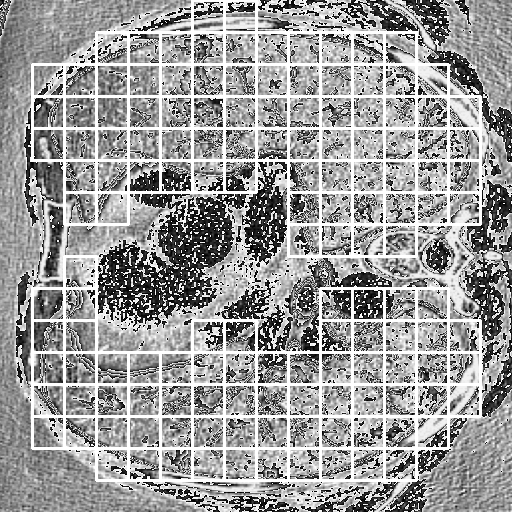

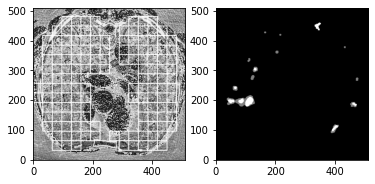

In [ ]:
# test for identifying infected 32x32 patche to create dataset 1
def checkForWhite(arr):
    for i in len(arr):
        if arr[i]>0:
            return True
        
    return False   

def checkForWhitePatch(x,y,imgArr):
    x*=32
    y*=32
    for i in range(x,x+32):
        for j in range(y,y+32):
            if imgArr[i][j]>0:
                return True   
    return False       

#function to run 32 by 32 with a contains function, 16 patches per row

i =0
detectedArr = []
for i in range(16):
   # if(checkForWhite(np.unique(array_2[i]))):
        for j in range(16):
            if(checkForWhitePatch(i,j,lungSliceArray)):
                #cv.rectangle(array_2,(i*32,j*32),(((i*32)+32,(j*32)+32)),(255,255,255),thickness=2)
                detectedArr.append((i,j))
#show_slices([slice_0, slice_1, slice_2])  
for c in range(len(detectedArr)) :
    cv.rectangle(dataSliceArrayII,(detectedArr[c][1]*32,detectedArr[c][0]*32),(((detectedArr[c][1]*32)+32,(detectedArr[c][0]*32)+32)),(255,255,255),thickness=2)

cv2_imshow(dataSliceArrayII)
cv.waitKey(0)
cv.destroyAllWindows()  
image2  = Image.fromarray(np.uint8(dataSliceArrayII * 255) , 'L')
image2.show()
affine = np.eye(4)
nifti_file = nib.Nifti1Image(dataSliceArrayII, affine).get_fdata()
show_slices([nifti_file,MaskSlice])

In [ ]:
# #create dataset 2 hopefully
# #print(len(func_data[1][1]))
# # if 1 on lungMask and 1 on infected n=mask then infected , if 1 on lung mask
# # and 0 on infected mask then non infected.
# #else discarded
# for i in range(100):
#     currentCT = func_data[:,:,i]
#     currentMask = mask_data[:,:,i]
#     currentLungMask = lung_mask_data[:,:,i]
#     # CTInfected = cv.bitwise_and(currentCT,currentMask)
#     # CTNonInfected =  cv.bitwise_and(currentCT,currentLungMask)
#     detectedInfectedArr = []
#     detectedNonInfectedArr = []
#     for i in range(16):
#         for j in range(16):
#             if(checkForWhitePatch(i,j,currentMask)):
#                 detectedInfectedArr.append((i,j))
#             else:
#                 if checkForWhitePatch(i, j, currentLungMask ):
#                     detectedNonInfectedArr.append((i,j))
#     for c in range(len(detectedInfectedArr)) : 
#         #10010_
#         imgID = 10000+i
#         patchIDSub=  10000+c
#         patchID =str(imgID)+'_'+str(patchIDSub)
#         currentPatch = currentCT[detectedInfectedArr[c][1]*32:(detectedInfectedArr[c][1]*32)+32,detectedInfectedArr[c][0]*32:(detectedInfectedArr[c][0]*32)+32]
#         imageio.imwrite(f'\Philo\GUC\Semester 8\VSCode Python Workspace\Replicate\Infected32x32\{patchID}.png',currentPatch )              
#     for d in range(len(detectedNonInfectedArr)) : 
#         #10010_
#         imgIDII = 10000+i
#         patchIDSubII=  10000+d
#         patchIDII =str(imgIDII)+'_'+str(patchIDSubII)
#         currentPatchII = currentCT[detectedNonInfectedArr[d][1]*32:(detectedNonInfectedArr[d][1]*32)+32,detectedNonInfectedArr[d][0]*32:(detectedNonInfectedArr[d][0]*32)+32]
#         imageio.imwrite(f'\Philo\GUC\Semester 8\VSCo`de Python Workspace\Replicate\Healthy32x32\{patchIDII}.png',currentPatchII)              
    
        

In [ ]:
test = cv.imread(r'/content/drive/MyDrive/Semester 8/Healthy32x32/10000_10001.png')
print(test)

[[167 171 177 ... 220 193 207]
 [148 187 173 ... 218 197 210]
 [137 194 164 ... 218 205 215]
 ...
 [239 212 218 ...  58  13  29]
 [255 179 243 ...  46  46  61]
 [231 174 218 ...  12  61  23]]


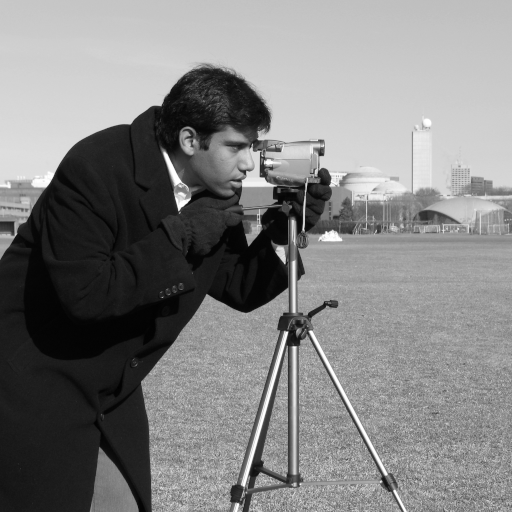

In [ ]:
PATCH_SIZE = 32
grass_locations = [(280, 454), (342, 223), (444, 192), (455, 455)]
grass_patches = []
image = data.camera()
cv2_imshow(image)
for loc in grass_locations:
    grass_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                               loc[1]:loc[1] + PATCH_SIZE])
grass_locations = [(280, 454), (342, 223), (444, 192), (455, 455)]
grass_patches = []
for loc in grass_locations:
    grass_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                               loc[1]:loc[1] + PATCH_SIZE])    
sky_locations = [(38, 34), (139, 28), (37, 437), (145, 379)]
sky_patches = []
for loc in sky_locations:
    sky_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                             loc[1]:loc[1] + PATCH_SIZE])    
    

(-0.5, 511.5, 511.5, -0.5)

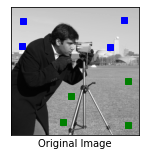

In [ ]:
# compute some GLCM properties each patch
xs = []
ys = []
for patch in (grass_patches + sky_patches):
    glcm = greycomatrix(patch, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
    xs.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    ys.append(greycoprops(glcm, 'correlation')[0, 0])
fig = plt.figure(figsize=(8, 8))
# display original image with locations of patches
ax = fig.add_subplot(3, 2, 1)
ax.imshow(image, cmap=plt.cm.gray,
          vmin=0, vmax=255)
for (y, x) in grass_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'gs')
for (y, x) in sky_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'bs')
ax.set_xlabel('Original Image')
ax.set_xticks([])
ax.set_yticks([])
ax.axis('image')    

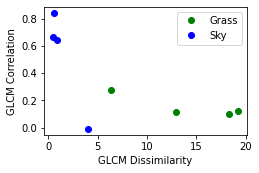

In [ ]:
# for each patch, plot (dissimilarity, correlation)
fig2 = plt.figure(figsize=(8, 8))
ax1 = fig2.add_subplot(3, 2, 2)
ax1.plot(xs[:len(grass_patches)], ys[:len(grass_patches)], 'go',
        label='Grass')
ax1.plot(xs[len(grass_patches):], ys[len(grass_patches):], 'bo',
        label='Sky')
ax1.set_xlabel('GLCM Dissimilarity')
ax1.set_ylabel('GLCM Correlation')
ax1.legend()

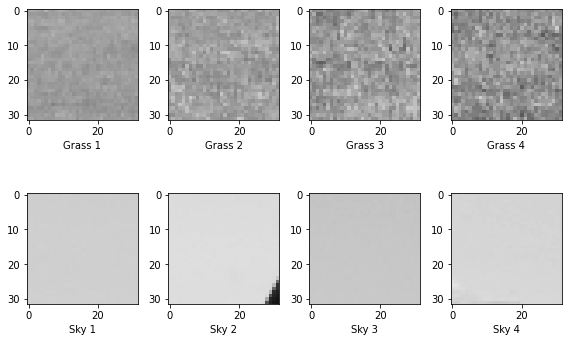

In [ ]:
# display the image patches
fig1 = plt.figure(figsize=(8, 8))
for i, patch in enumerate(grass_patches):
    ax1 = fig1.add_subplot(3, len(grass_patches), len(grass_patches)*1 + i + 1)
    ax1.imshow(patch, cmap=plt.cm.gray,
              vmin=0, vmax=255)
    ax1.set_xlabel('Grass %d' % (i + 1))

for i, patch in enumerate(sky_patches):
    ax1 = fig1.add_subplot(3, len(sky_patches), len(sky_patches)*2 + i + 1)
    ax1.imshow(patch, cmap=plt.cm.gray,
              vmin=0, vmax=255)
    ax1.set_xlabel('Sky %d' % (i + 1))


# display the patches and plot
fig.suptitle('Grey level co-occurrence matrix features', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

In [2]:
DATADIR = r'/content/drive/MyDrive/Semester 8'
Categories=['Healthy32x32','Infected32x32']
X=[]
y=[]
i=0

for i in Categories:
    path=os.path.join(DATADIR,i)
    for imgX in os.listdir(path):
      #print(path)
      newpath = os.path.join(path,imgX)
      #print(newpath)
      image = cv.imread(newpath,-1)
      imArr = np.array(image)
      #print(imArr)
      X.append(imArr)
      y.append(i)
       
print(X[0])

# X_train, X_test, y_train, y_test = train_test_split(X,
#                                                     y,
#                                                     test_size=.3,
#                                                     random_state=1234123)

[[207 220 214 ... 254 225 182]
 [234 244 251 ... 194 183 188]
 [225 208 216 ... 154 154 172]
 ...
 [187 167 179 ...  11  12  28]
 [210 178 207 ...  13  40  73]
 [245 201 204 ...  22  55  88]]


In [ ]:

DATADIR = r'/content/drive/MyDrive/Semester 8'
Categories=['Healthy32x32','Infected32x32']
X=[]
y=[]
i=0
# zzz =   sitk.ReadImage(newpath)
# print(zzz)

for i in Categories:
    path=os.path.join(DATADIR,i)
    for imgX in os.listdir(path):
      #print(path)
      newpath = os.path.join(path,imgX)
      #print(newpath)
      image = sitk.ReadImage(newpath)
      imArr = np.array(image)
      #print(imArr)
      X.append(image)
      y.append(i)
       
print(X[0])

Image (0x55e18520aa40)
  RTTI typeinfo:   itk::Image<unsigned char, 2u>
  Reference Count: 1
  Modified Time: 3169504
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 3169494
  UpdateMTime: 3169503
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 2
    Index: [0, 0]
    Size: [32, 32]
  BufferedRegion: 
    Dimension: 2
    Index: [0, 0]
    Size: [32, 32]
  RequestedRegion: 
    Dimension: 2
    Index: [0, 0]
    Size: [32, 32]
  Spacing: [1, 1]
  Origin: [0, 0]
  Direction: 
1 0
0 1

  IndexToPointMatrix: 
1 0
0 1

  PointToIndexMatrix: 
1 0
0 1

  Inverse Direction: 
1 0
0 1

  PixelContainer: 
    ImportImageContainer (0x55e183d40af0)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, unsigned char>
      Reference Count: 1
      Modified Time: 3169500
      Debug: Off
      Object Name: 
      Observers: 
        n

In [3]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y)
test_labels_encoded = le.transform(y)
print(len(test_labels_encoded))
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    test_labels_encoded,
                                                    test_size=.3,
                                                    random_state=1234123)
print(test_labels_encoded)

10249
[0 0 0 ... 1 1 1]


In [ ]:
def feature_extractor(dataset):
    image_dataset = pd.DataFrame()
    for image in range(len(dataset)):
        df = pd.DataFrame()  #Temporary data frame to capture information for each loop.
        #Reset dataframe to blank after each loop.
        
        img = dataset[image]
        print(img)
        ip = radiomics.glcm.RadiomicsGLCM._initCalculation(img)
        #START ADDING DATA TO THE DATAFRAME       
        #Full image
        #GLCM = greycomatrix(img, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])
        #GLCM = greycomatrix(img, [1], [0])  
        ###### FEATURES #####     
        # GLCM_Energy = greycoprops(GLCM, 'energy')[0]
        # df['Energy'] = GLCM_Energy
        #correlation
        GLCM_corr = radiomics.glcm.RadiomicsGLCM.getCorrelationFeatureValue(ip)
        df['Corr'] = GLCM_corr     
        #dissimilarity  
        GLCM_diss = radiomics.glcm.RadiomicsGLCM.getDifferenceAverageFeatureValue(ip)
        df['Diss_sim'] = GLCM_diss    
        #homogeneity i.e inverse difference   
        GLCM_hom = radiomics.glcm.RadiomicsGLCM.getIdFeatureValue(ip)
        df['Homogen'] = GLCM_hom    
        #contrast   
        GLCM_contr = radiomics.glcm.RadiomicsGLCM.getContrastFeatureValue(ip)
        df['Contrast'] = GLCM_contr
        #entropy
        entropy = shannon_entropy(ip)
        df['Entropy'] = entropy
        #angular secondary moment
        GLCM_ASM = radiomics.glcm.RadiomicsGLCM.getJointEnergyFeatureValue(ip)
        df['ASM'] = GLCM_ASM
        #sum of squares
        GLCM_SSQ= radiomics.glcm.RadiomicsGLCM.getSumSquaresFeatureValue(ip)
        df['SSQ'] = GLCM_SSQ
        #inverse difference moment
        GLCM_IDM= radiomics.glcm.RadiomicsGLCM.getIdmFeatureValue(ip)
        df['IDM'] = GLCM_IDM
        #sum average
        GLCM_SA= radiomics.glcm.RadiomicsGLCM.getSumAverageFeatureValue(ip)
        df['SA'] = GLCM_SA
        #sum variance
        GLCM_SV= radiomics.glcm.RadiomicsGLCM.getClusterTendencyFeatureValue(ip)
        df['SV'] = GLCM_SV
        #sum entropy 
        GLCM_SE= radiomics.glcm.RadiomicsGLCM.getSumEntropyFeatureValue(ip)
        df['SE'] = GLCM_SE
        #difference entropy (13)
        GLCM_DE= radiomics.glcm.RadiomicsGLCM.getDifferenceEntropyFeatureValue(ip)
        df['DE'] = GLCM_DE
        #difference variance
        GLCM_DV= radiomics.glcm.RadiomicsGLCM.getDifferenceVarianceFeatureValue(ip)
        df['DV'] = GLCM_DV
        #informational measures of correlation 1
        GLCM_IMC1= radiomics.glcm.RadiomicsGLCM.getImc1FeatureValue(ip)
        df['IMC1'] = GLCM_IMC1
        #informational measures of correlation 2
        GLCM_IMC2= radiomics.glcm.RadiomicsGLCM.getImc2FeatureValue(ip)
        df['IMC2'] = GLCM_IMC2
        #autocorrelation
        GLCM_AC= radiomics.glcm.RadiomicsGLCM.getAutocorrelationFeatureValue(ip)
        df['AC'] = GLCM_AC
        #cluster shade
        GLCM_CS= radiomics.glcm.RadiomicsGLCM.getClusterShadeFeatureValue(ip)
        df['CS'] = GLCM_CS
        #cluster prominence
        GLCM_CP= radiomics.glcm.RadiomicsGLCM.getClusterProminenceFeatureValue(ip)
        df['CP'] = GLCM_CP
        #maximum probability (20)
        GLCM_MP= radiomics.glcm.RadiomicsGLCM.getMaximumProbabilityFeatureValue(ip)
        df['MP'] = GLCM_MP

        #Append features from current image to the dataset
        image_dataset = image_dataset.append(df)
        
    return image_dataset

In [ ]:
print( sitk.GetArrayFromImage(X[10248]))

[[ 47 139 214 ...  36 134 218]
 [ 77 193 255 ...  33  78 159]
 [ 85 156 182 ...  51  55  98]
 ...
 [ 26  22  27 ...  48  41  44]
 [ 31   4   8 ...  68  66  64]
 [ 37  24  12 ...  79  74  64]]


In [6]:
#another try with GLCM features
from radiomics import firstorder,  imageoperations, shape, shape2D
settings = {'binWidth': 1,
            'interpolator': sitk.sitkBSpline,
            'resampledPixelSpacing': None}
trialImg = sitk.GetImageFromArray(X[10248])
# im_size = im.GetSize()[::-1]  # size in z, y, x, needed because the arrays obtained from the image are oriented in z, y, x

ma_arr = np.ones([32,32], dtype='uint8')
ma = sitk.GetImageFromArray(ma_arr)
ma.CopyInformation(trialImg)  # This copies the geometric information, ensuring image and mask are aligned. This works, because image and mask have the same size of the pixel array

sitk.WriteImage(ma, r'/content/drive/MyDrive/Semester 8/mask.nrrd', True)  # don't forget the extension!, True specifies it can be compressed for storage (only used for masks)

trialMask = sitk.ReadImage(r'/content/drive/MyDrive/Semester 8/mask.nrrd')
applyLog = False
applyWavelet = False
interpolator = settings.get('interpolator')
resampledPixelSpacing = settings.get('resampledPixelSpacing')
if interpolator is not None and resampledPixelSpacing is not None:
  image, mask = imageoperations.resampleImage(trialImg, trialMask, **settings)

bb, correctedMask = imageoperations.checkMask(trialImg, trialMask)
if correctedMask is not None:
  mask = correctedMask
print(f'Berfore :{sitk.GetArrayFromImage(trialImg)}')  
image, mask = imageoperations.cropToTumorMask(trialImg, trialMask, bb)
print(f'Aftore :{sitk.GetArrayFromImage(trialImg)}')  
#
# Show the first order feature calculations
#
# firstOrderFeatures = firstorder.RadiomicsFirstOrder(trialImg, trialMask, **settings)

# firstOrderFeatures.enableFeatureByName('Mean', True)
# # firstOrderFeatures.enableAllFeatures()

# print('Will calculate the following first order features: ')
# for f in firstOrderFeatures.enabledFeatures.keys():
#   print('  ', f)
#   print(getattr(firstOrderFeatures, 'get%sFeatureValue' % f).__doc__)

# print('Calculating first order features...')
# results = firstOrderFeatures.execute()
# print('done')

# print('Calculated first order features: ')
# for (key, val) in six.iteritems(results):
#   print('  ', key, ':', val)

# #
# # Show Shape features
# #
# shapeFeatures = shape2D.RadiomicsShape2D(trialImg, trialMask, **settings)
# shapeFeatures.enableAllFeatures()

# print('Will calculate the following Shape features: ')
# for f in shapeFeatures.enabledFeatures.keys():
#   print('  ', f)
#   print(getattr(shapeFeatures, 'get%sFeatureValue' % f).__doc__)

# print('Calculating Shape features...')
# results = shapeFeatures.execute()
# print('done')

# print('Calculated Shape features: ')
# for (key, val) in six.iteritems(results):
#   print('  ', key, ':', val)

glcmFeatures = glcm.RadiomicsGLCM(trialImg, trialMask ,**settings)
glcmFeatures.enableFeatureByName('JointEnergy',True)
glcmFeatures.enableFeatureByName('Contrast',True)
glcmFeatures.enableFeatureByName('Correlation',True)
glcmFeatures.enableFeatureByName('SumSquares',True)
glcmFeatures.enableFeatureByName('Idm',True)
glcmFeatures.enableFeatureByName('SumAverage',True)
glcmFeatures.enableFeatureByName('ClusterTendency',True)
glcmFeatures.enableFeatureByName('SumEntropy',True)
# glcmFeatures.enableFeatureByName('Entropy',True)
glcmFeatures.enableFeatureByName('DifferenceEntropy',True)
glcmFeatures.enableFeatureByName('DifferenceVariance',True)
glcmFeatures.enableFeatureByName('Imc1',True)
glcmFeatures.enableFeatureByName('Imc2',True)
glcmFeatures.enableFeatureByName('Autocorrelation',True)
glcmFeatures.enableFeatureByName('DifferenceAverage',True)
glcmFeatures.enableFeatureByName('ClusterShade',True)
glcmFeatures.enableFeatureByName('ClusterProminence',True)
glcmFeatures.enableFeatureByName('MaximumProbability',True)
glcmFeatures.enableFeatureByName('Id',True)

print('Will calculate the following GLCM features: ')
for f in glcmFeatures.enabledFeatures.keys():
  print('  ', f)
  print(getattr(glcmFeatures, 'get%sFeatureValue' % f).__doc__)

print('Calculating GLCM features...')
resultsII = glcmFeatures.execute()
print('done')

print('Calculated GLCM features: ')
arrTrX = []
for (key, val) in six.iteritems(resultsII):
  print('  ', key, ':', val)
  arrTrX.append(float(val))
arrTrX

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Berfore :[[ 47 139 214 ...  36 134 218]
 [ 77 193 255 ...  33  78 159]
 [ 85 156 182 ...  51  55  98]
 ...
 [ 26  22  27 ...  48  41  44]
 [ 31   4   8 ...  68  66  64]
 [ 37  24  12 ...  79  74  64]]
Aftore :[[ 47 139 214 ...  36 134 218]
 [ 77 193 255 ...  33  78 159]
 [ 85 156 182 ...  51  55  98]
 ...
 [ 26  22  27 ...  48  41  44]
 [ 31   4   8 ...  68  66  64]
 [ 37  24  12 ...  79  74  64]]
Will calculate the following GLCM features: 
   JointEnergy

    **11. Joint Energy**

    .. math::
      \textit{joint energy} = \displaystyle\sum^{N_g}_{i=1}\displaystyle\sum^{N_g}_{j=1}{\big(p(i,j)\big)^2}

    Energy is a measure of homogeneous patterns
    in the image. A greater Energy implies that there are more instances
    of intensity value pairs in the image that neighbor each other at
    higher frequencies.

    .. note::
      Defined by IBSI as Angular Second Moment.
    
   Contrast

    **6. Contrast**

    .. math::
      \textit{contrast} = \displaystyle\sum^{N_g}_{i=1}\d

[0.000679765891811747,
 994.2885991155064,
 0.6419572977800597,
 1392.061918629532,
 0.049862187366061,
 117.62600806451613,
 4573.959075402621,
 7.539333880350884,
 5.865461454651147,
 446.1375546700777,
 -0.4399295061666835,
 0.9987593873203207,
 4353.995171045788,
 23.167094823100935,
 500543.92524132214,
 137617644.8477431,
 0.002560809053069719,
 0.10739504902245982]

In [ ]:
#another another try with features
def feature_extractorII(dataset):
    image_dataset = pd.DataFrame()
    for image in range(len(dataset)):  #iterate through each file 
        #print(image)
        
        df = pd.DataFrame()  #Temporary data frame to capture information for each loop.
        #Reset dataframe to blank after each loop.
        
        img = dataset[image]
    ################################################################
    #START ADDING DATA TO THE DATAFRAME
  
                
         #Full image
        #GLCM = greycomatrix(img, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])
        GLCM = greycomatrix(img, [1], [0])   
        print(len(GLCM[0]))
        break
        GLCM_Energy = greycoprops(GLCM, 'energy')[0]
        df['Energy'] = GLCM_Energy
        GLCM_corr = greycoprops(GLCM, 'correlation')[0]
        df['Corr'] = GLCM_corr       
        GLCM_diss = greycoprops(GLCM, 'dissimilarity')[0]
        df['Diss_sim'] = GLCM_diss       
        GLCM_hom = greycoprops(GLCM, 'homogeneity')[0]
        df['Homogen'] = GLCM_hom       
        GLCM_contr = greycoprops(GLCM, 'contrast')[0]
        df['Contrast'] = GLCM_contr
        
        #Add more filters as needed
        #entropy = shannon_entropy(img)
        #df['Entropy'] = entropy

        
        #Append features from current image to the dataset
        image_dataset = image_dataset.append(df)
        
    return image_dataset

In [ ]:
# print(len(image_features))
# print(image_features.iloc[0])
eskot = []
i=0
j=0
for i in range(32):
  Odarr=[]
  for j in range(32):
    Odarr.append(1)
  eskot.append(Odarr)
print(eskot)

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 

In [ ]:
print('Eskot')

Eskot


In [ ]:
#another another another try with features
import statistics
def feature_extractorIII(dataset):
    image_dataset = pd.DataFrame()
    for image in range(len(dataset)):  #iterate through each file 
        #print(image)
        df = pd.DataFrame()  #Temporary data frame to capture information for each loop.
        #Reset dataframe to blank after each loop.
        
        img = dataset[image]
        print('GLCM')
    ################################################################
    #START ADDING DATA TO THE DATAFRAME
  
                
         #Full image
        #GLCM = greycomatrix(img, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])
        GLCM = greycomatrix(img, [1], [0])   
        print('GLCM')
        print(GLCM)
        
        # GLCM_Energy = greycoprops(GLCM, 'energy')[0]
        # df['Energy'] = GLCM_Energy
        GLCM_corr = greycoprops(GLCM, 'correlation')[0]
        df['Corr'] = GLCM_corr       
        GLCM_diss = greycoprops(GLCM, 'dissimilarity')[0]
        df['Diss_sim'] = GLCM_diss       
        GLCM_hom = greycoprops(GLCM, 'homogeneity')[0]
        df['Homogen'] = GLCM_hom       
        GLCM_contr = greycoprops(GLCM, 'contrast')[0]
        df['Contrast'] = GLCM_contr
        
        #Add more filters as needed
        entropy = shannon_entropy(img)
        df['Entropy'] = entropy
         #angular secondary moment
        GLCM_ASM = greycoprops(GLCM, 'ASM')[0]
        df['ASM'] = GLCM_ASM
        #sum of squares
        GLCM_SSQ= radiomics.glcm.RadiomicsGLCM.getSumSquaresFeatureValue(ip)
        df['SSQ'] = GLCM_SSQ
        #inverse difference moment
        GLCM_IDM= radiomics.glcm.RadiomicsGLCM.getIdmFeatureValue(ip)
        df['IDM'] = GLCM_IDM
        #sum average
        GLCM_SA= radiomics.glcm.RadiomicsGLCM.getSumAverageFeatureValue(ip)
        df['SA'] = GLCM_SA
        #sum variance
        GLCM_SV= radiomics.glcm.RadiomicsGLCM.getClusterTendencyFeatureValue(ip)
        df['SV'] = GLCM_SV
        #sum entropy 
        GLCM_SE= radiomics.glcm.RadiomicsGLCM.getSumEntropyFeatureValue(ip)
        df['SE'] = GLCM_SE
        #difference entropy (13)
        GLCM_DE= radiomics.glcm.RadiomicsGLCM.getDifferenceEntropyFeatureValue(ip)
        df['DE'] = GLCM_DE
        #difference variance
        GLCM_DV= radiomics.glcm.RadiomicsGLCM.getDifferenceVarianceFeatureValue(ip)
        df['DV'] = GLCM_DV
        #informational measures of correlation 1
        GLCM_IMC1= radiomics.glcm.RadiomicsGLCM.getImc1FeatureValue(ip)
        df['IMC1'] = GLCM_IMC1
        #informational measures of correlation 2
        GLCM_IMC2= radiomics.glcm.RadiomicsGLCM.getImc2FeatureValue(ip)
        df['IMC2'] = GLCM_IMC2
        #autocorrelation
        GLCM_AC= radiomics.glcm.RadiomicsGLCM.getAutocorrelationFeatureValue(ip)
        df['AC'] = GLCM_AC
        #cluster shade
        GLCM_CS= radiomics.glcm.RadiomicsGLCM.getClusterShadeFeatureValue(ip)
        df['CS'] = GLCM_CS
        #cluster prominence
        GLCM_CP= radiomics.glcm.RadiomicsGLCM.getClusterProminenceFeatureValue(ip)
        df['CP'] = GLCM_CP
        #maximum probability (20)
        GLCM_MP= radiomics.glcm.RadiomicsGLCM.getMaximumProbabilityFeatureValue(ip)
        df['MP'] = GLCM_MP

        print(len(GLCM[0][0][0]))
        #Append features from current image to the dataset
        image_dataset = image_dataset.append(df)
        break
    return image_dataset


In [6]:
def feature_extractorGLCM(dataset):
    image_dataset = []
    for image in range(len(dataset)):   #Temporary data frame to capture information for each loop.
        #Reset dataframe to blank after each loop.
        iterImg = sitk.GetImageFromArray(X[image])
        trialMask = sitk.ReadImage(r'/content/drive/MyDrive/Semester 8/mask.nrrd')
        applyLog = False
        applyWavelet = False
        interpolator = settings.get('interpolator')
        resampledPixelSpacing = settings.get('resampledPixelSpacing')
        if interpolator is not None and resampledPixelSpacing is not None:
          image, mask = imageoperations.resampleImage(iterImg, trialMask, **settings)

        bb, correctedMask = imageoperations.checkMask(iterImg, trialMask)
        if correctedMask is not None:
          mask = correctedMask
        image, mask = imageoperations.cropToTumorMask(iterImg, trialMask, bb)
        
        

        glcmFeatures = glcm.RadiomicsGLCM(iterImg, trialMask ,**settings)
        glcmFeatures.enableFeatureByName('JointEnergy',True)
        glcmFeatures.enableFeatureByName('Contrast',True)
        glcmFeatures.enableFeatureByName('Correlation',True)
        glcmFeatures.enableFeatureByName('SumSquares',True)
        glcmFeatures.enableFeatureByName('Idm',True)
        glcmFeatures.enableFeatureByName('SumAverage',True)
        glcmFeatures.enableFeatureByName('ClusterTendency',True)
        glcmFeatures.enableFeatureByName('SumEntropy',True)
        # glcmFeatures.enableFeatureByName('Entropy',True)
        glcmFeatures.enableFeatureByName('DifferenceEntropy',True)
        glcmFeatures.enableFeatureByName('DifferenceVariance',True)
        glcmFeatures.enableFeatureByName('Imc1',True)
        glcmFeatures.enableFeatureByName('Imc2',True)
        glcmFeatures.enableFeatureByName('Autocorrelation',True)
        glcmFeatures.enableFeatureByName('DifferenceAverage',True)
        glcmFeatures.enableFeatureByName('ClusterShade',True)
        glcmFeatures.enableFeatureByName('ClusterProminence',True)
        glcmFeatures.enableFeatureByName('MaximumProbability',True)
        glcmFeatures.enableFeatureByName('Id',True)

        
        results = glcmFeatures.execute()
        resArray=[]
        for (key, val) in six.iteritems(results):
          resArray.append(float(val))
        #Append features from current image to the dataset
        image_dataset.append(resArray)
    return image_dataset

In [4]:
def feature_extractorFOS(dataset):
    image_dataset = []
    for image in range(len(dataset)):   #Temporary data frame to capture information for each loop.
        #Reset dataframe to blank after each loop.
        iterImg = sitk.GetImageFromArray(X[image])
        trialMask = sitk.ReadImage(r'/content/drive/MyDrive/Semester 8/mask.nrrd')
        applyLog = False
        applyWavelet = False
        interpolator = settings.get('interpolator')
        resampledPixelSpacing = settings.get('resampledPixelSpacing')
        if interpolator is not None and resampledPixelSpacing is not None:
          image, mask = imageoperations.resampleImage(iterImg, trialMask, **settings)

        bb, correctedMask = imageoperations.checkMask(iterImg, trialMask)
        if correctedMask is not None:
          mask = correctedMask
        image, mask = imageoperations.cropToTumorMask(iterImg, trialMask, bb)
        
        
        firstOrderFeatures = firstorder.RadiomicsFirstOrder(iterImg, trialMask, **settings)
        firstOrderFeatures.enableAllFeatures()

        
        results = glcmFeatures.execute()
        resArray=[]
        for (key, val) in six.iteritems(results):
          resArray.append(float(val))
        #Append features from current image to the dataset
        image_dataset.append(resArray)
    return image_dataset

In [7]:

image_features = feature_extractorFOS(X_train)
X_for_ML = image_features
#X_for_ML_mod = X_for_ML
# print(len(image_features))
# print(image_features.iloc[0])
# print('Feature Extraction Done')
# print(len(image_features))
svm = SVC(kernel='rbf', probability=True, random_state=42)

# fit model
svm.fit(X_for_ML, y_train)
print('Model Fitted Successfully')

import pickle
filename = '/content/drive/MyDrive/Semester 8/FOS_SVM_RBF_modelI_binWidth1.sav'
pickle.dump(svm, open(filename, 'wb'))

Streaming output truncated to the last 5000 lines.
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is s

Model Fitted Successfully


In [ ]:
import pickle
filename = '/content/drive/MyDrive/Semester 8/GLCM_SVM_Linear_modelII.sav'
pickle.dump(svm, open(filename, 'wb'))
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

Model accuracy is:  0.5534959349593496


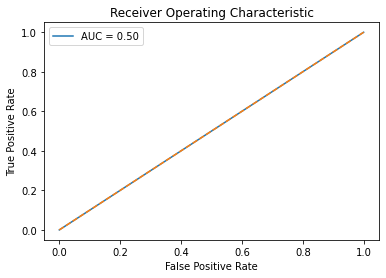

In [9]:
test_image_features = feature_extractorFOS(X_test)
y_pred = svm.predict(test_image_features)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)
# predict probabilities for X_test using predict_proba
probabilities = svm.predict_proba(test_image_features)

# select the probabilities for label 1.0
y_proba = probabilities[:, 1]

# calculate false positive rate and true positive rate at different thresholds
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba, pos_label=1)

# calculate AUC
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
# plot the false positive rate on the x axis and the true positive rate on the y axis
roc_plot = plt.plot(false_positive_rate,
                    true_positive_rate,
                    label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');